<a href="https://colab.research.google.com/github/concaption/PepsiCo-Lab-Potato-Quality-Control/blob/main/Potato_Starter_Code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  
import datetime
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
# -- Global Variables -- 
TRAIN_PATH = '/content/drive/MyDrive/Pepsico RnD Potato Lab Dataset/Train'
TEST_PATH = '/content/drive/MyDrive/Pepsico RnD Potato Lab Dataset/Test'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
TARGET_SIZE = (255, 255)
GRAY_SCALL = (3,)
INPUT_SIZE = TARGET_SIZE + GRAY_SCALL
EPOCHS = 10
CLASSES = ['Defective','Non-Defective']

In [ ]:
# -- Data Normalization --
data_generator = ImageDataGenerator(samplewise_center=True, #making sure that each image has a mean of 0
                                    samplewise_std_normalization=True, #and standard deviation 1
                                    horizontal_flip=True, #Randomly flip inputs horizontally
                                    validation_split=0.3,
                                    )

In [ ]:
# -- Data iterators -- 
train_data = data_generator.flow_from_directory(directory=TRAIN_PATH,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                color_mode=COLOR_MODE,
                                                subset='training',
                                                shuffle=True)         
    
validation_data = data_generator.flow_from_directory(directory=TRAIN_PATH,
                                                     target_size=TARGET_SIZE,
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     color_mode=COLOR_MODE,
                                                     subset='validation',
                                                     shuffle=True)             

test_data = data_generator.flow_from_directory(directory=TEST_PATH,
                                               target_size=TARGET_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               color_mode=COLOR_MODE,
                                               shuffle=True)

Found 539 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

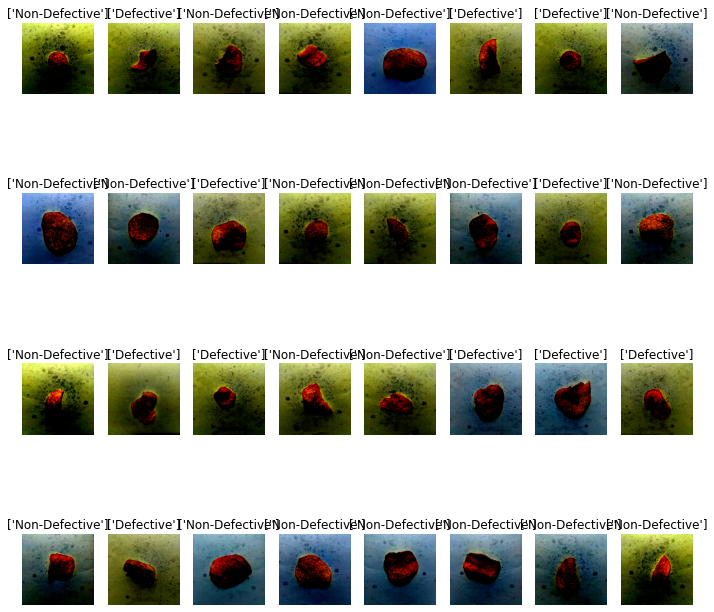

In [ ]:
# -- plot random batch -- 
images, labels = train_data.next()
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 8, figsize=(12,12))
axs = axs.flatten()
for img, label, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    label = label.astype(int)
    ax.set_title(classes[label == 1])
plt.show()

In [ ]:
def my_model():
  vgg19_model = VGG19(weights='imagenet',include_top=False,input_shape=INPUT_SIZE)
  vgg19_model.trainable = False
  flatten =Flatten()(vgg19_model.layers[-1].output)
  fc1 = Dense(units=4096, activation ='relu')(flatten)
  dropout = Dropout(0.2)(fc1)
  fc2 = Dense(units=1024,activation='relu')(dropout)
  output = Dense(2, activation='softmax')(fc2)
  model = Model(inputs = vgg19_model.input, outputs=output)
  model.summary()
  return model

In [ ]:
model = my_model()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 255, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 255, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 255, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
______________________________________________________________

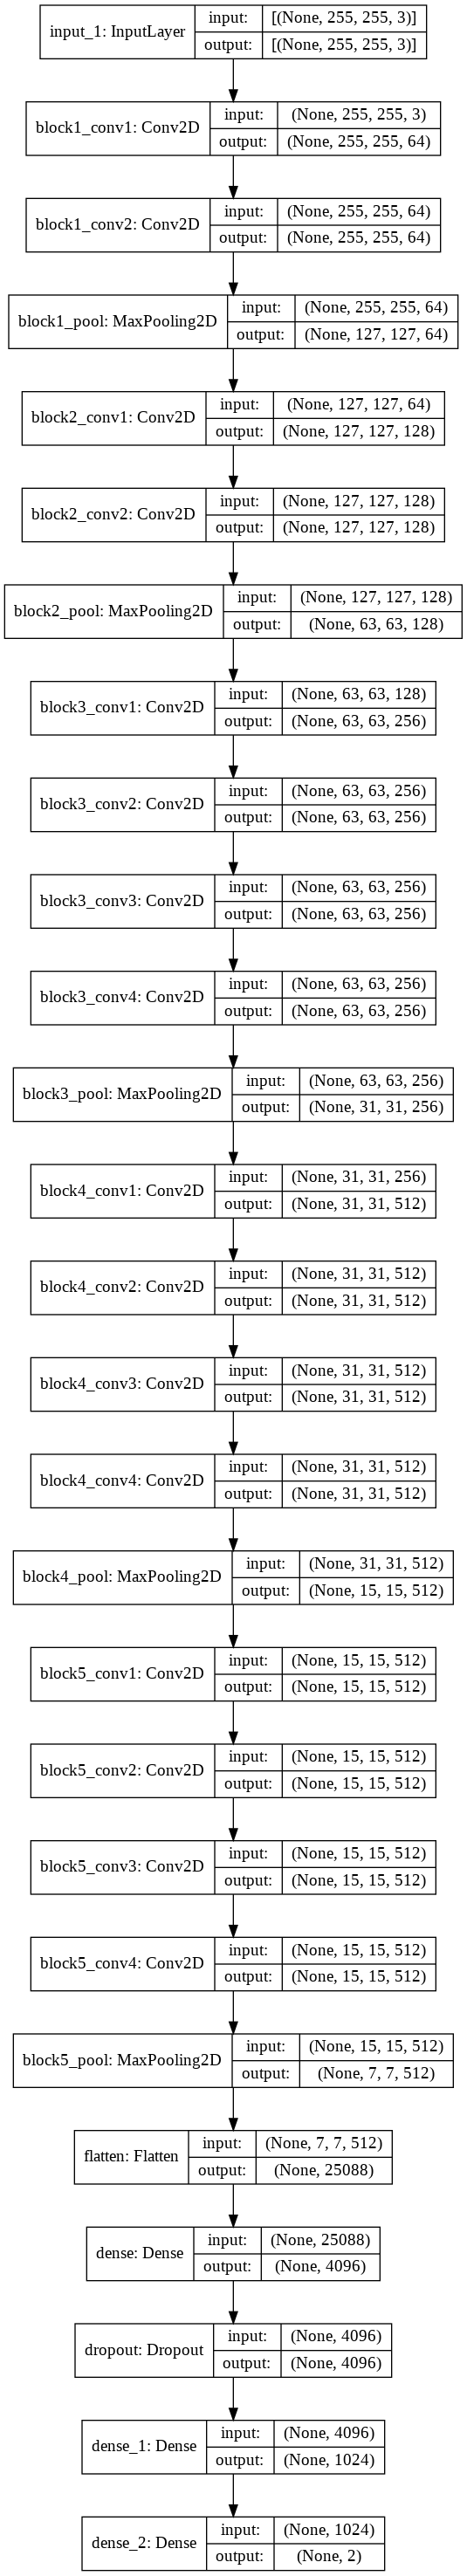

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='T', expand_nested=False, dpi=96
)

In [ ]:
# -- Define optimizer and loss --
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# -- Compile model --
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [ ]:
 # -- Callbacks --
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_model.h5', 
                                                    monitor='accuracy', verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False, 
                                                    mode='auto', 
                                                    save_freq='epoch')
    
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                    min_delta=0, 
                                                    patience=5,  #Number of epochs with no improvement after which training will be stopped.
                                                    verbose=1, 
                                                    mode='auto')
    
log_dir = './logs/fit/' + datetime.datetime.now().strftime('%m.%d.%Y--%H-%M-%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                 histogram_freq=1, 
                                                 write_graph=True,
                                                 write_images=False, 
                                                 update_freq='epoch')

In [ ]:
# -- Train model --
history = model.fit(x=train_data, 
                        epochs=EPOCHS, 
                        steps_per_epoch=len(train_data), 
                        verbose=1, 
                        validation_data=validation_data, 
                        validation_steps=1, 
                        callbacks=[checkpoint, earlystoping, tensorboard])
    
# -- Save model -- 
model.save('my_model.h5')

Epoch 1/10
17/17 [==============================] - 559s 32s/step - loss: 15.4959 - accuracy: 0.4932 - val_loss: 1.6378 - val_accuracy: 0.4375

Epoch 00001: accuracy improved from -inf to 0.51391, saving model to my_model.h5
Epoch 2/10
17/17 [==============================] - 530s 31s/step - loss: 0.5853 - accuracy: 0.7464 - val_loss: 0.1918 - val_accuracy: 0.9062

Epoch 00002: accuracy improved from 0.51391 to 0.85158, saving model to my_model.h5
Epoch 3/10
17/17 [==============================] - 527s 31s/step - loss: 0.0665 - accuracy: 0.9723 - val_loss: 0.0474 - val_accuracy: 1.0000

Epoch 00003: accuracy improved from 0.85158 to 0.98516, saving model to my_model.h5
Epoch 4/10
17/17 [==============================] - 522s 31s/step - loss: 0.0222 - accuracy: 0.9944 - val_loss: 0.1649 - val_accuracy: 0.9688

Epoch 00004: accuracy improved from 0.98516 to 0.99443, saving model to my_model.h5
Epoch 5/10
17/17 [==============================] - 520s 30s/step - loss: 0.0086 - accuracy: 0

In [ ]:
def learning_curves(history):
    '''plot learning curves'''
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss - Cross Entropy')
    plt.xlabel('epoch')
    plt.ylim([0,1.6])
    plt.title('Training and Validation Loss')
    
    plt.show()

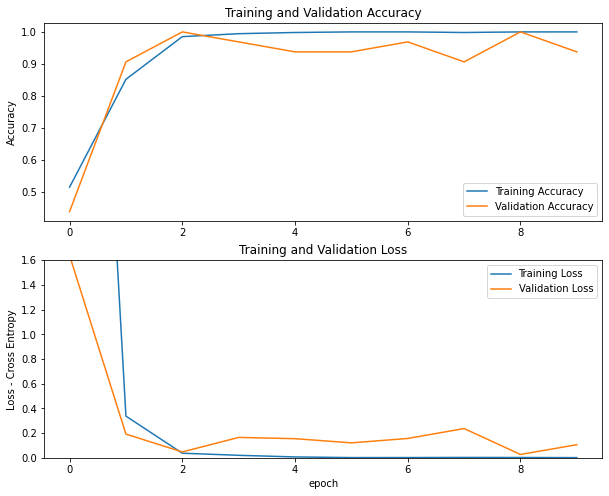

In [ ]:
# -- Plot learning curves -- 
learning_curves(history)

In [ ]:
# -- Evaluate the model on the test data -- 
loss, accuracy = model.evaluate(x=test_data)
print("test loss: ", loss, ", test acc: " , 100*accuracy, "%")

In [ ]:
def defective_or_not(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(255,255,3))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    model = tf.keras.models.load_model('my_model.h5')
    output = model.predict(img)
    print(classes[output[0]==1])